## Setup

In [1]:
from transformer_lens import (HookedTransformer, utils)
from transformer_lens.hook_points import HookPoint
import functools
import torch
import matplotlib.pyplot as plt
from jaxtyping import Float, Int
from torch import Tensor
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from transformers import PatchTSTForPrediction
from transformers.models.patchtst.modeling_patchtst import (
    PatchTSTForPredictionOutput
)

import numpy as np
from sklearn.linear_model import (
    LinearRegression, 
    LogisticRegression, 
    LogisticRegressionCV, 
    Lasso, 
    LassoCV, 
    LassoLarsCV)
from sklearn.metrics import (mean_absolute_error, mean_squared_error, accuracy_score)
from sklearn.linear_model import Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
from data_loader import *
import datasets
import pandas as pd
from scipy.stats import (pearsonr, pointbiserialr)
from scipy import signal
from scipy.fft import fft, fftfreq
import einops

import torch.nn.functional as F
from sklearn.manifold import TSNE

In [2]:
# patchtst = HookedTransformer.from_pretrained("patchtst")
# patchtst_transformer = PatchTSTForPrediction.from_pretrained("../models/patchtst_tsmixup_final").to(device)

patchtst = HookedTransformer.from_pretrained("patchtst_relu", center_unembed=False)
patchtst_transformer = PatchTSTForPrediction.from_pretrained("Coaster41/patchtst-tsmixup-relu").to(device)

Loaded pretrained model patchtst_relu into HookedTransformer


In [3]:
# Loading tsmixup dataset
train_dataset, val_dataset = create_cached_tsmixup_datasets(
        max_samples=300000,
        context_length=512,
        prediction_length=96, # 1 or 96
        num_workers=16,
        cache_dir="/extra/datalab_scratch0/ctadler/time_series_models/mechanistic_interpretability/data/tsmixup_cache/",
        processed_cache_path="/extra/datalab_scratch0/ctadler/time_series_models/mechanistic_interpretability/data/tsmixup_cache/tsmixup_processed_300000_512_96.pkl",
        batch_size=4000
    )

🚀 CREATING CACHED TSMIXUP DATASETS
📂 Found existing processed data at /extra/datalab_scratch0/ctadler/time_series_models/mechanistic_interpretability/data/tsmixup_cache/tsmixup_processed_300000_512_96.pkl
⚡ Loading preprocessed data from cache...
✅ Loaded 174,209 preprocessed samples
📅 Cache created: 2025-08-03 15:05:17

📊 DATASET SUMMARY:
  Total processed samples: 174,209
  Context length: 512
  Prediction length: 96
🔀 Shuffling data...
📈 Data split:
  Training samples: 156,788
  Validation samples: 17,421
  Train ratio: 90.0%
🏗️  Creating PyTorch datasets...
🏗️  Dataset created with 156,788 samples
📊 Augmentation: ON
📈 Dataset Statistics (from 1000 samples):
  Sequence lengths: min=608, max=2043, mean=1320
  Value ranges: min=-49.2103, max=70.9532
  Value stats: mean=0.9038, std=2.2952
🏗️  Dataset created with 17,421 samples
📊 Augmentation: OFF
📈 Dataset Statistics (from 1000 samples):
  Sequence lengths: min=608, max=2048, mean=1284
  Value ranges: min=-28.6077, max=79.0030
  Value

In [ ]:
def generate_sin(a, p, m=0):
    if not torch.is_tensor(m):
        m = torch.zeros_like(p)
    rows = p.shape[0] if torch.is_tensor(p) else 1
    cols = m.shape[0] if torch.is_tensor(m) else 1
    b = 2*torch.pi / p
    x = torch.arange(512).repeat(cols, rows, 1)
    x = (a * torch.sin(x * b[None, :, None]) + m[:, None, None] * x).to(device)
    x = torch.flatten(x, start_dim=0, end_dim=1)
    return x

def ar_predictions(model, x, pred_length=96, ctx_len=None, out_len=None):
    if ctx_len is None:
        ctx_len = model.cfg.n_ctx
    if out_len is None:
        out_len = model.cfg.prediction_length
    y = []
    with torch.no_grad():
        for i in range(pred_length // out_len):
            if i > 0:
                x = torch.cat((x[:, out_len:], y[-1]), dim=1)
            out = model(x)
            if isinstance(out, PatchTSTForPredictionOutput):
                out = out.prediction_outputs
            y.append(out)
        
    return torch.cat(y, dim=1)

def load_dataset(dataset, ts=1000, pred_length=1, ctx_len=512):
    if dataset == 'tsmixup':
        x = []
        y = []
        for i in range(ts) if isinstance(ts, int) else ts:
            val_dict = val_dataset[i]
            x.append(val_dict['past_values'])
            y.append(val_dict['future_values'])
        x = torch.stack(x)[:, -ctx_len:]
        y = torch.stack(y)[:,:pred_length]
        
    else:
        dataset_path = f"../../ts_foundation_calibration/data/{dataset}/y_{dataset}.csv"
        timestamp_column = "ds"

        data = pd.read_csv(
            dataset_path,
            parse_dates=[timestamp_column],
            index_col=0
        )

        x = []
        for id, vals in data.groupby('unique_id'):
            x.append(torch.from_numpy(vals['y'].to_numpy(np.float32)))
        x = torch.stack(x)

    if dataset != 'tsmixup':
        y = x[:,ctx_len:ctx_len+pred_length]
        x = x[:,:ctx_len]
    return x, y

def get_activations(
    attn_pattern: Float[Tensor, "batch num_patches d_mlp"],
    hook: HookPoint,
    activations: Float[Tensor, "batch num_patches d_mlp"]
) -> Float[Tensor, "batch num_patches d_mlp"]:
    activations[:] = attn_pattern
    return attn_pattern

# Can we predict period from MLP activations?

In [5]:
# Run model with activations

# Load Sine waves with trends
a = 1
# Periods range from [20, 100]
p = torch.arange(20, 101)
# Slope ranges from [-0.01, 0.01]
m = torch.arange(0, 101) / 5000 - 0.01
x = generate_sin(a, p, m)

# Load MLP forward hooks to get activations
mlp_activations = []
mlp_hooks = []
for i in range(patchtst.cfg.n_layers):
    mlp_activation = torch.zeros((x.shape[0], patchtst.cfg.num_patches, patchtst.cfg.d_mlp))
    mlp_activations.append(mlp_activation)
    get_mlp_activations = functools.partial(get_activations, activations=mlp_activation)
    mlp_hooks.append((f"blocks.{i}.mlp.hook_post", get_mlp_activations))

# Run Model
y = patchtst.run_with_hooks(x, fwd_hooks=mlp_hooks)

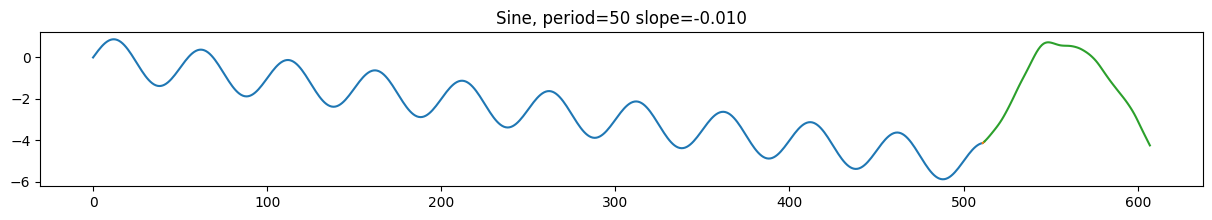

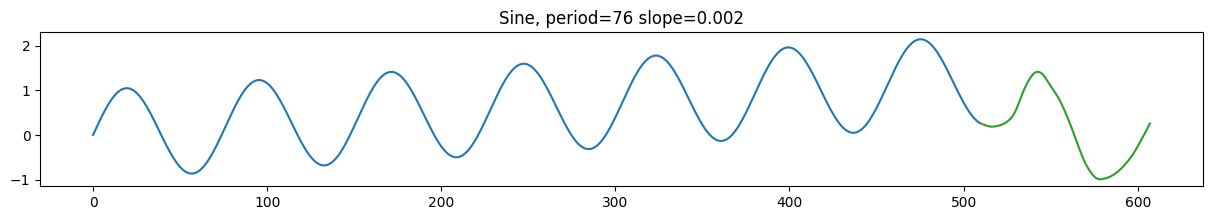

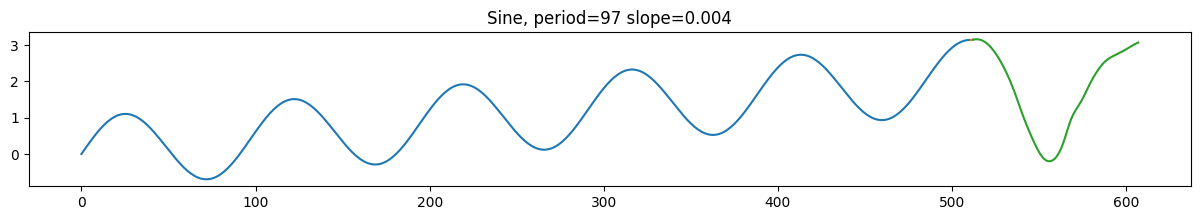

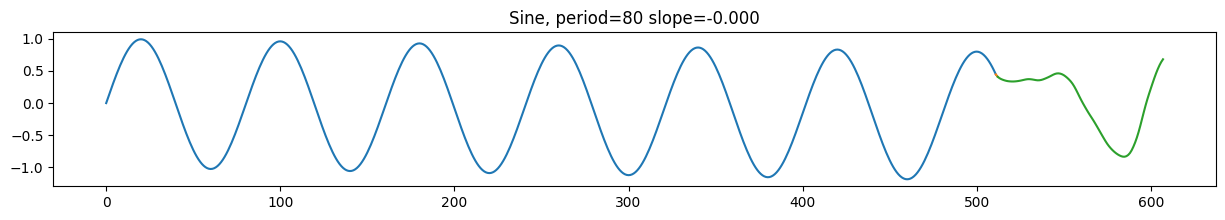

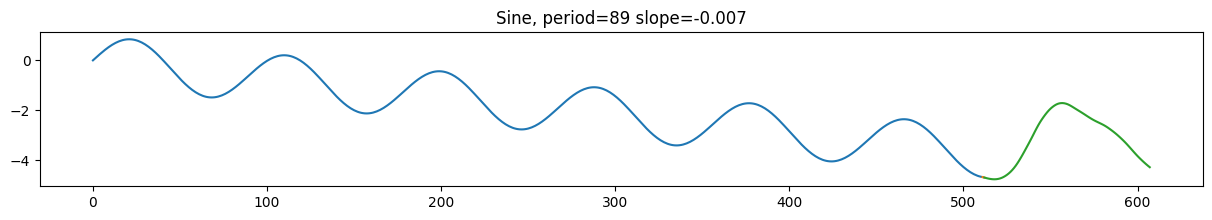

In [6]:
# Various Plots
# batches = [10,-100,300,5001,3231,1543]
batches = np.random.randint(0,x.shape[0], 5)
plt_x = x[batches]
y_ar = ar_predictions(patchtst, x[batches])
# y_ar_transformer = ar_predictions(patchtst_transformer, x[batches,:,None], ctx_len=512, out_len=1)[:,:,0]

for batch in range(len(batches)):
    plt.figure(figsize=(15,2))
    plt.plot(plt_x[batch].detach().cpu())
    plt.plot([511,512], [plt_x[batch,-1].item(), y_ar[batch,0].item()])
    plt.plot(torch.arange(y_ar.shape[1]) + 512, y_ar[batch].detach().cpu().numpy())
    trend, period = torch.unravel_index(torch.tensor(batches[batch]), (m.shape[0], p.shape[0]))
    plt.title(f"Sine, period={p[period]} slope={m[trend]:.3f}")
    plt.show()

## Can Features be learned from Neuron Activations using LR or Lasso LR?

In [9]:
# Train a LR and Lasso model to predict period or trend 
layer = 0
patch = [31] # [31]
X = mlp_activations[layer][:, patch].flatten(start_dim=1).detach().cpu()
# Use period or slope
use_period = False
print(f"Predicting {'Period' if use_period else 'Slope'}")
y = p.repeat(m.shape[0], 1) if use_period else m.repeat(p.shape[0], 1).T
y = y.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(f"LR MAE: {mean_absolute_error(y_test, y_pred):.2E} MSE: {mean_squared_error(y_test, y_pred):.2E}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# lasso = Lasso(alpha=0.0001)
lasso = LassoLarsCV()
lasso.fit(X_train_scaled, y_train)
y_lasso = lasso.predict(X_test_scaled)
print(f"Lasso LR MAE: {mean_absolute_error(y_test, y_lasso):.2E} MSE: {mean_squared_error(y_test, y_lasso):.2E} Non-zero coef: {np.sum(lasso.coef_ != 0)}")
# print(y)

Predicting Slope
LR MAE: 2.99E-04 MSE: 1.43E-07
Lasso LR MAE: 2.92E-04 MSE: 1.35E-07 Non-zero coef: 162


/extra/datalab_scratch0/ctadler/time_series_models/uni2ts/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.031e-04, tolerance: 2.505e-05
  model = cd_fast.enet_coordinate_descent(
/extra/datalab_scratch0/ctadler/time_series_models/uni2ts/venv/lib/python3.10/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/extra/datalab_scratch0/ctadler/time_series_models/uni2ts/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/extra/datalab_scratch0/cta

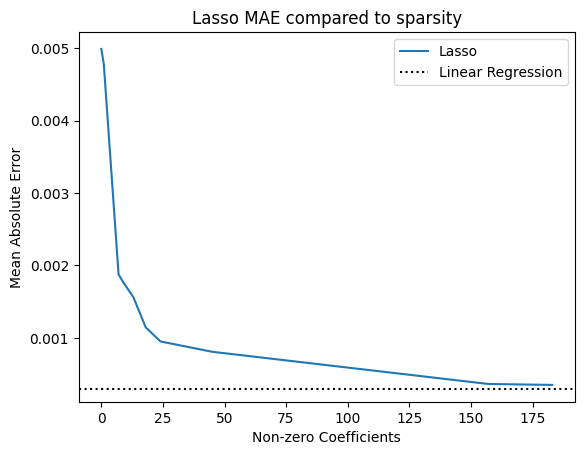

In [10]:
# Plotting Lasso performance with varying sparsity
alphas = np.array([3,2,1,0.5,0.2,0.1,0.07,0.05,0.02,0.01,0.0075,0.005,0.001,0.00075,0.0005,0.0002,0.0001,0.00005,0.000001,0])
lasso_mae = []
lasso_sparse = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_scaled, y_train)
    y_lasso = lasso.predict(X_test_scaled)
    lasso_mae.append(mean_absolute_error(y_test, y_lasso))
    lasso_sparse.append(np.sum(lasso.coef_ != 0))

plt.plot(lasso_sparse, lasso_mae, label='Lasso')
plt.axhline(mean_absolute_error(y_test, y_pred), c='black', ls=':', label='Linear Regression')
plt.xlabel("Non-zero Coefficients")
plt.ylabel("Mean Absolute Error")
plt.title("Lasso MAE compared to sparsity")
plt.legend()
plt.show()

## Neuron-Feature Correlation

In [15]:
# Get Absolute Valued Pearson Correlation
use_period = False
print(f"Predicting {'Period' if use_period else 'Slope'}")
y = p.repeat(m.shape[0], 1) if use_period else m.repeat(p.shape[0], 1).T
y = y.flatten()
y_other = p.repeat(m.shape[0], 1) if not use_period else m.repeat(p.shape[0], 1).T
y_other = y_other.flatten()

corr = torch.zeros((patchtst.cfg.n_layers, patchtst.cfg.num_patches, patchtst.cfg.d_mlp))
for layer in range(patchtst.cfg.n_layers):
    for patch in tqdm(range(patchtst.cfg.num_patches)):
        for neuron in range(patchtst.cfg.d_mlp):
            correlation, _ = pearsonr(mlp_activations[layer][:, patch, neuron].detach().cpu(), y)
            corr[layer, patch, neuron] = torch.tensor(correlation)

corr = torch.abs(torch.nan_to_num(corr, 0))

Predicting Slope


  0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_1931713/638707398.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = pearsonr(mlp_activations[layer][:, patch, neuron].detach().cpu(), y)
100%|██████████| 32/32 [00:03<00:00,  8.51it/s]


Top 10 neurons with the highest correlation to slope:
Correlation: 0.963 layer: 0, patch: 0, neuron: 91
Correlation: 0.961 layer: 0, patch: 0, neuron: 222
Correlation: 0.959 layer: 0, patch: 0, neuron: 69
Correlation: 0.948 layer: 0, patch: 0, neuron: 225
Correlation: 0.946 layer: 2, patch: 0, neuron: 86
Correlation: 0.944 layer: 0, patch: 0, neuron: 126
Correlation: 0.944 layer: 0, patch: 0, neuron: 70
Correlation: 0.943 layer: 0, patch: 0, neuron: 64
Correlation: 0.940 layer: 1, patch: 0, neuron: 91
Correlation: 0.934 layer: 2, patch: 2, neuron: 242
Error when predicting from the best neuron
LR MAE: 1.29E-03 MSE: 2.46E-06


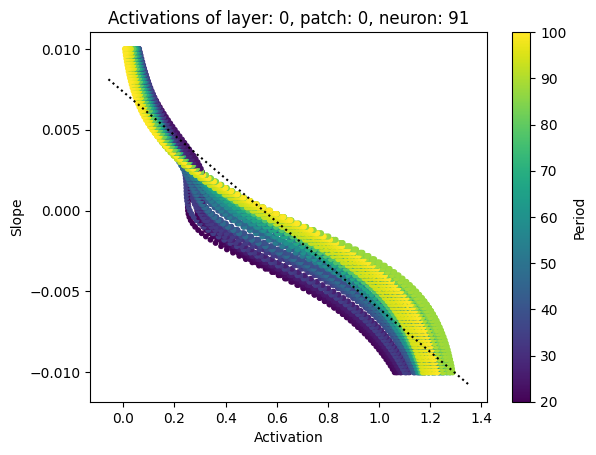

In [16]:
# Get Correlation of neurons with period/trend
k = 10
top10_values, top10_ind = torch.topk(corr.flatten(), k=k)
print(f"Top {k} neurons with the highest correlation to {'period' if use_period else 'slope'}:")
for val, ind in zip(top10_values, top10_ind):
    layer, patch, neuron = torch.unravel_index(ind, corr.shape)
    print(f"Correlation: {val:.3f} layer: {layer.item()}, patch: {patch.item()}, neuron: {neuron.item()}")
    
# Plot best activations against period
global_argmax = torch.argmax(corr)
layer, patch, neuron = torch.unravel_index(global_argmax, corr.shape)

X = mlp_activations[layer][:, patch, neuron][:,None].detach().cpu()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("Error when predicting from the best neuron")
print(f"LR MAE: {mean_absolute_error(y_test, y_pred):.2E} MSE: {mean_squared_error(y_test, y_pred):.2E}")


plt.scatter(mlp_activations[layer][:, patch, neuron].detach().cpu(), y, s=10, c=y_other)
plt.ylabel(f"{'Period' if use_period else 'Slope'}")
plt.xlabel("Activation")
xmin, xmax = plt.xlim()
plt.plot([xmin, xmax], reg.predict([[xmin], [xmax]]), c='black', ls=':')
cbar = plt.colorbar()
cbar.solids.set_edgecolor("face")
cbar.set_label('Period' if not use_period else 'Slope')
plt.title(f"Activations of layer: {layer.item()}, patch: {patch.item()}, neuron: {neuron.item()}")
plt.show()

In [17]:
# Does the neuron with the highest correlation the same over patches
max_val, max_ind = torch.max(corr, dim=2)
neuron_corr = torch.mean(corr, dim=1)
topk_avg, topk_ind = torch.topk(neuron_corr, k=5, dim=1)
for layer in range(max_val.shape[0]):
    print(f"Layer: {layer}")
    counts = torch.bincount(max_ind[layer])
    count_dict = {i: count.item() for i, count in enumerate(counts) if count > 0}
    sorted_by_count = dict(sorted(count_dict.items(), key=lambda x: x[1], reverse=True))
    print(f"Neurons with max correlation per patch: {sorted_by_count}")
    dict_topk = dict(zip(topk_ind[layer].tolist(), [float(f"{i:.3f}") for i in topk_avg[layer].tolist()]))
    print(f"Average Correlation from top neurons: {dict_topk}")

Layer: 0
Neurons with max correlation per patch: {187: 6, 12: 3, 62: 3, 77: 3, 10: 2, 30: 2, 194: 2, 246: 2, 64: 1, 66: 1, 91: 1, 96: 1, 98: 1, 100: 1, 107: 1, 188: 1, 236: 1}
Average Correlation from top neurons: {250: 0.575, 58: 0.571, 238: 0.558, 107: 0.558, 145: 0.545}
Layer: 1
Neurons with max correlation per patch: {52: 8, 185: 6, 114: 3, 243: 3, 58: 2, 102: 2, 194: 2, 241: 2, 48: 1, 91: 1, 115: 1, 188: 1}
Average Correlation from top neurons: {84: 0.743, 194: 0.695, 185: 0.658, 56: 0.637, 253: 0.637}
Layer: 2
Neurons with max correlation per patch: {76: 9, 129: 8, 13: 3, 69: 3, 177: 3, 35: 2, 81: 2, 86: 1, 242: 1}
Average Correlation from top neurons: {177: 0.74, 85: 0.706, 238: 0.694, 13: 0.692, 59: 0.677}


# What are the distribution of neuron activations?

In [5]:
# Run model and get activations on tsmixup
batch_size = 1000
activations = [[] for _ in range(patchtst.cfg.n_layers)]

for i in tqdm(range(len(val_dataset) // batch_size)):
    ts = torch.arange(batch_size) + batch_size * i
    x, _ =  load_dataset('tsmixup', torch.arange(batch_size) + i*batch_size)
    mlp_activations = []
    mlp_hooks = []
    for i in range(patchtst.cfg.n_layers):
        mlp_activation = torch.zeros((x.shape[0], patchtst.cfg.num_patches, patchtst.cfg.d_mlp))
        mlp_activations.append(mlp_activation)
        get_mlp_activations = functools.partial(get_activations, activations=mlp_activation)
        mlp_hooks.append((f"blocks.{i}.mlp.hook_post", get_mlp_activations))

    y = patchtst.run_with_hooks(x, fwd_hooks=mlp_hooks)
    for i in range(patchtst.cfg.n_layers):
        activations[i].append(mlp_activations[i].detach().cpu())
        
all_activations = torch.stack([torch.cat(layer) for layer in activations])

100%|██████████| 17/17 [00:01<00:00, 11.25it/s]


## Distribution of Neuron activation sparsity

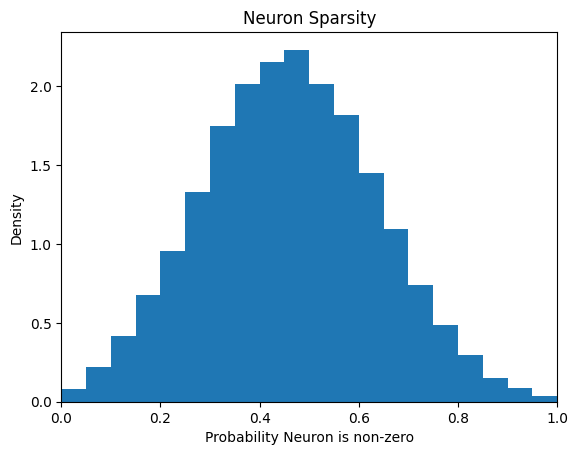

In [19]:
# How sparse are the MLP neuron activations
sparsity = torch.zeros((patchtst.cfg.n_layers, patchtst.cfg.patch_length, patchtst.cfg.d_mlp))
for layer in range(patchtst.cfg.n_layers):
    for patch in range(patchtst.cfg.patch_length):
        for neuron in range(patchtst.cfg.d_mlp):
            sparsity[layer, patch, neuron] = torch.sum(all_activations[layer, :, patch, neuron] > 0) / all_activations.shape[1]
hist, bins, _ = plt.hist(sparsity.flatten(), bins=torch.arange(21)/20, density=True)
plt.xlim(0,1)
plt.title("Neuron Sparsity")
plt.xlabel("Probability Neuron is non-zero")
plt.ylabel("Density")
plt.show()

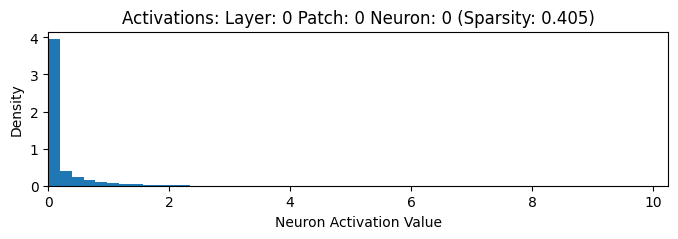

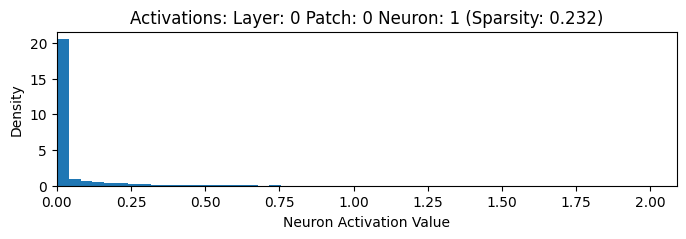

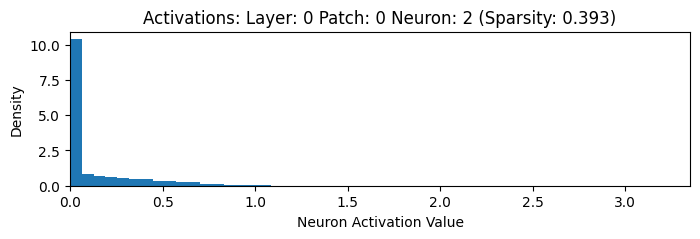

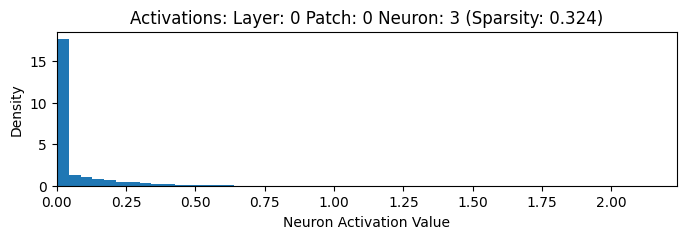

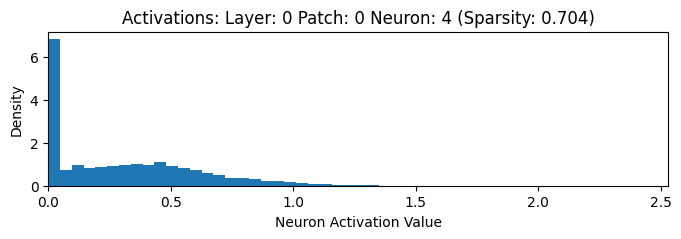

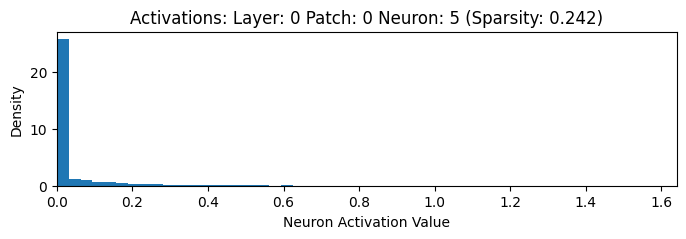

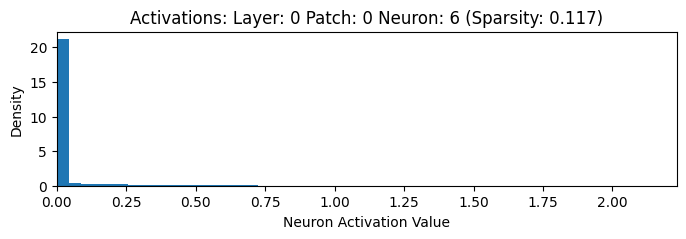

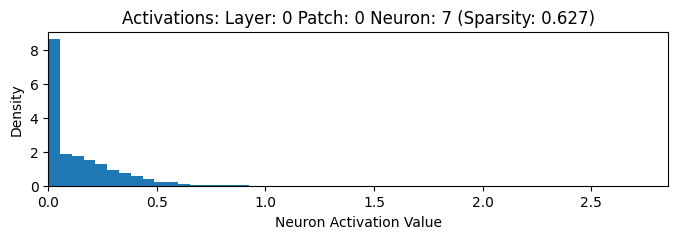

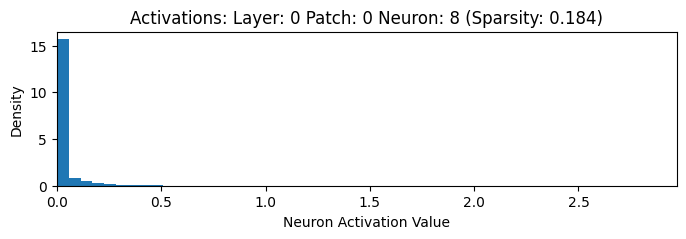

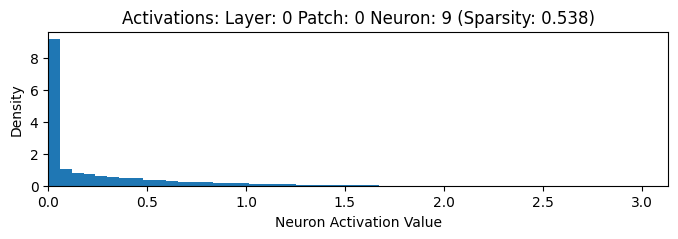

In [ ]:
# Plot neuron activations
layer = 0
patch = 0
# neuron = 0

for neuron in range(10):
    plt.figure(figsize=(8,2))
    hist, bins, _ = plt.hist(all_activations[layer, :, patch, neuron], bins=50, density=True)
    plt.xlim(0, None)
    plt.title(f"Activations: Layer: {layer} Patch: {patch} Neuron: {neuron} (Sparsity: {torch.mean((all_activations[layer, :, patch, neuron] > 0).float()):.3f})")
    plt.xlabel("Neuron Activation Value")
    plt.ylabel("Density")
    plt.show()

## Are time series that activate on sparse neurons share an interpretable feature?

In [20]:
# Search for sparse neurons
layers = [0] # range(patchtst.cfg.n_layers)
patches = range(patchtst.cfg.num_patches) # range(patchtst.cfg.num_patches)
neurons = range(patchtst.cfg.d_mlp) # range(patchtst.cfg.d_mlp)
min_sparsity = 1e-5
max_sparsity = 0.001

neuron_sparsities = torch.mean((all_activations > 0).float(), dim=1)
neuron_sparsity_mask = (neuron_sparsities >= min_sparsity) & (neuron_sparsities <= max_sparsity)
search_space_mask = torch.zeros_like(neuron_sparsities)
layers_idx, patches_idx, neurons_idx = torch.meshgrid(
    torch.tensor(layers), 
    torch.tensor(patches), 
    torch.tensor(neurons), 
    indexing='ij'
)
search_space_mask[layers_idx.flatten(), patches_idx.flatten(), neurons_idx.flatten()] = 1
sparse_neurons = torch.nonzero(neuron_sparsity_mask * search_space_mask)

for sparse_indicies in sparse_neurons:
    neuron_sparsity = neuron_sparsities[tuple(sparse_indicies.tolist())]
    active_nerons = int(neuron_sparsity*all_activations.shape[1])
    print(f"Layer: {sparse_indicies[0]} Patch: {sparse_indicies[1]} Neuron: {sparse_indicies[2]} has sparsity {neuron_sparsity:.4f} ({active_nerons}/{all_activations.shape[1]})")

Layer: 0 Patch: 30 Neuron: 55 has sparsity 0.0001 (2/17000)
Layer: 0 Patch: 30 Neuron: 135 has sparsity 0.0001 (2/17000)
Layer: 0 Patch: 31 Neuron: 35 has sparsity 0.0005 (8/17000)
Layer: 0 Patch: 31 Neuron: 41 has sparsity 0.0010 (17/17000)
Layer: 0 Patch: 31 Neuron: 46 has sparsity 0.0009 (15/17000)
Layer: 0 Patch: 31 Neuron: 55 has sparsity 0.0002 (2/17000)
Layer: 0 Patch: 31 Neuron: 105 has sparsity 0.0001 (2/17000)
Layer: 0 Patch: 31 Neuron: 162 has sparsity 0.0002 (4/17000)
Layer: 0 Patch: 31 Neuron: 193 has sparsity 0.0006 (10/17000)
Layer: 0 Patch: 31 Neuron: 217 has sparsity 0.0009 (16/17000)
Layer: 0 Patch: 31 Neuron: 229 has sparsity 0.0010 (17/17000)


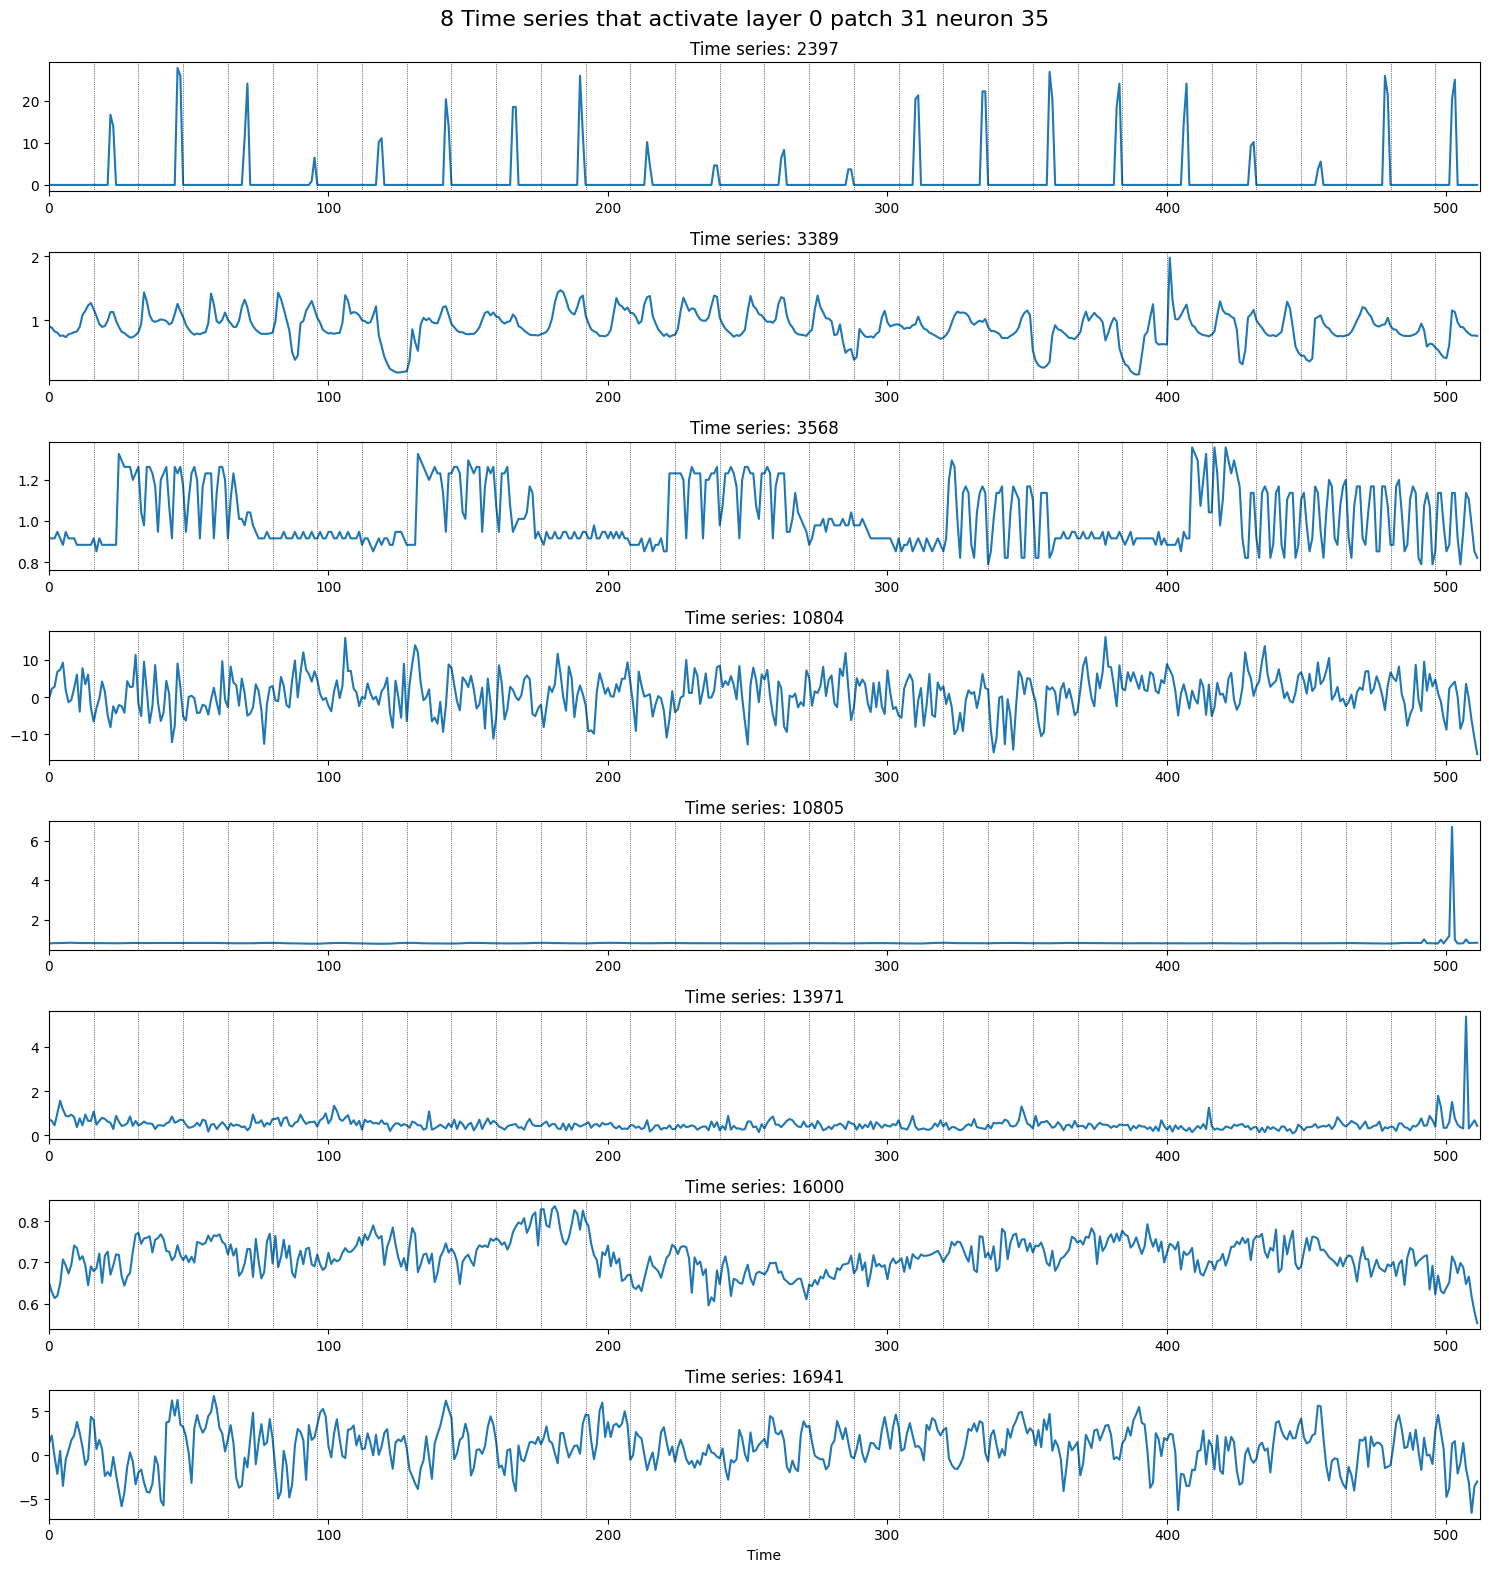

In [22]:
# Plot time series that activate a specific neuron
layer = 0
patch = 31
neuron = 35
indicies = torch.nonzero(all_activations[layer, :, patch, neuron] > 0)
x, y = load_dataset('tsmixup', ts = indicies)

num_batches = x.shape[0]
fig, axes = plt.subplots(num_batches, 1, figsize=(15, 2*num_batches))

# Handle case where there's only one batch (axes won't be an array)
if num_batches == 1:
    axes = [axes]

# Plot each batch in its own subplot
for batch in range(num_batches):
    axes[batch].plot(x[batch])
    for i in range(33):
        axes[batch].axvline(16*i, lw=0.5, ls=':', c='black')
    axes[batch].set_xlim(0, 512)
    axes[batch].set_title(f'Time series: {indicies[batch].item()}')


plt.xlabel("Time")
plt.suptitle(f"{x.shape[0]} Time series that activate layer {layer} patch {patch} neuron {neuron}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1-num_batches*0.001])
plt.show()

# Neuron activations after dilation

In [24]:
def fourier_dilation(x, dilation_factor, context_length=None):
    """
    Dilate a time series using Fourier-based interpolation with configurable output length.
    - When stretching (factor > 1): truncates the beginning of the sequence
    - When compressing (factor < 1): pads the beginning of the sequence
    
    Args:
        x (torch.Tensor): Input tensor of shape (batch_size, sequence_length)
        dilation_factor (float): Factor by which to dilate the signal
                                > 1.0: stretch (slower playback, truncate beginning)
                                < 1.0: compress (faster playback, pad beginning)
        context_length (int, optional): Final output sequence length. 
                                       If None, uses input sequence length.
    
    Returns:
        torch.Tensor: Dilated tensor of shape (batch_size, context_length)
    """
    batch_size, seq_len = x.shape
    device = x.device
    dtype = x.dtype
    
    # Set context_length to input length if not specified
    if context_length is None:
        context_length = seq_len
    
    # Handle edge cases
    if dilation_factor == 1.0 and context_length == seq_len:
        return x.clone()
    
    # Compute FFT
    X_fft = torch.fft.fft(x, dim=-1)
    
    # Determine new sequence length after dilation
    new_seq_len = int(seq_len * dilation_factor)
    
    if dilation_factor > 1.0:
        # Stretching: zero-pad in frequency domain
        
        # Zero-pad the FFT coefficients
        if seq_len % 2 == 0:
            # Even length: split DC and Nyquist carefully
            X_padded = torch.zeros(batch_size, new_seq_len, dtype=X_fft.dtype, device=device)
            
            # Copy positive frequencies
            X_padded[:, :seq_len//2] = X_fft[:, :seq_len//2]
            # Copy negative frequencies
            X_padded[:, -seq_len//2:] = X_fft[:, -seq_len//2:]
        else:
            # Odd length: simpler case
            X_padded = torch.zeros(batch_size, new_seq_len, dtype=X_fft.dtype, device=device)
            
            # Copy positive frequencies
            X_padded[:, :(seq_len+1)//2] = X_fft[:, :(seq_len+1)//2]
            # Copy negative frequencies
            X_padded[:, -(seq_len//2):] = X_fft[:, -(seq_len//2):]
        
        # Scale to preserve energy
        X_padded *= dilation_factor
        
        # Inverse FFT to get stretched signal
        x_stretched = torch.fft.ifft(X_padded, dim=-1).real
        
        # Handle output length adjustment
        if new_seq_len >= context_length:
            # Truncate from the beginning to get desired context_length
            start_idx = new_seq_len - context_length
            x_output = x_stretched[:, start_idx:]
        else:
            # Stretched signal is shorter than context_length, pad at beginning
            pad_len = context_length - new_seq_len
            padding = torch.zeros(batch_size, pad_len, dtype=dtype, device=device)
            x_output = torch.cat([padding, x_stretched], dim=-1)
        
    else:
        # Compressing: truncate in frequency domain
        
        new_seq_len = max(1, new_seq_len)  # Ensure at least length 1
        
        # Create truncated frequency domain representation
        X_truncated = torch.zeros(batch_size, new_seq_len, dtype=X_fft.dtype, device=device)
        
        if new_seq_len % 2 == 0:
            # Even length
            # Copy low frequencies (positive)
            copy_len_pos = min(new_seq_len//2, seq_len//2)
            X_truncated[:, :copy_len_pos] = X_fft[:, :copy_len_pos]
            
            # Copy low frequencies (negative)
            copy_len_neg = min(new_seq_len//2, seq_len//2)
            X_truncated[:, -copy_len_neg:] = X_fft[:, -copy_len_neg:]
        else:
            # Odd length
            # Copy low frequencies (positive including DC)
            copy_len_pos = min((new_seq_len+1)//2, (seq_len+1)//2)
            X_truncated[:, :copy_len_pos] = X_fft[:, :copy_len_pos]
            
            # Copy low frequencies (negative)
            copy_len_neg = min(new_seq_len//2, seq_len//2)
            X_truncated[:, -copy_len_neg:] = X_fft[:, -copy_len_neg:]
        
        # Scale to preserve energy
        X_truncated *= dilation_factor
        
        # Inverse FFT to get compressed signal
        x_compressed = torch.fft.ifft(X_truncated, dim=-1).real
        
        # Handle output length adjustment
        if new_seq_len >= context_length:
            # Compressed signal is longer than context_length, truncate from beginning
            start_idx = new_seq_len - context_length
            x_output = x_compressed[:, start_idx:]
        else:
            # Compressed signal is shorter than context_length, pad at beginning
            pad_len = context_length - new_seq_len
            padding = torch.zeros(batch_size, pad_len, dtype=dtype, device=device)
            x_output = torch.cat([padding, x_compressed], dim=-1)
    
    return x_output.to(dtype)


def linear_dilation(x, dilation_factor, context_length=None):
    """
    Dilate a time series using linear interpolation with configurable output length.
    - When stretching (factor > 1): truncates the beginning of the sequence
    - When compressing (factor < 1): pads the beginning of the sequence
    
    Args:
        x (torch.Tensor): Input tensor of shape (batch_size, sequence_length)
        dilation_factor (float): Factor by which to dilate the signal
                                > 1.0: stretch (slower playback, truncate beginning)
                                < 1.0: compress (faster playback, pad beginning)
        context_length (int, optional): Final output sequence length. 
                                       If None, uses input sequence length.
    
    Returns:
        torch.Tensor: Dilated tensor of shape (batch_size, context_length)
    """
    batch_size, seq_len = x.shape
    device = x.device
    dtype = x.dtype
    
    # Set context_length to input length if not specified
    if context_length is None:
        context_length = seq_len
    
    # Handle edge cases
    if dilation_factor == 1.0 and context_length == seq_len:
        return x.clone()
    
    # Determine new sequence length after dilation
    new_seq_len = int(seq_len * dilation_factor)
    new_seq_len = max(1, new_seq_len)  # Ensure at least length 1
    
    # Create dilated sequence using linear interpolation
    x_dilated = torch.zeros(batch_size, new_seq_len, dtype=dtype, device=device)
    
    for i in range(new_seq_len):
        # Map dilated index back to original index
        original_index = i / dilation_factor
        
        # Get integer bounds
        lower_idx = int(torch.floor(torch.tensor(original_index)).item())
        upper_idx = int(torch.ceil(torch.tensor(original_index)).item())
        
        # Clamp indices to valid range
        lower_idx = max(0, min(seq_len - 1, lower_idx))
        upper_idx = max(0, min(seq_len - 1, upper_idx))
        
        if lower_idx == upper_idx:
            # Exact index match
            x_dilated[:, i] = x[:, lower_idx]
        else:
            # Linear interpolation
            weight = original_index - lower_idx
            x_dilated[:, i] = x[:, lower_idx] * (1 - weight) + x[:, upper_idx] * weight
    
    # Handle output length adjustment
    if new_seq_len >= context_length:
        # Truncate from the beginning to get desired context_length
        start_idx = new_seq_len - context_length
        x_output = x_dilated[:, start_idx:]
    else:
        # Dilated signal is shorter than context_length, pad at beginning
        pad_len = context_length - new_seq_len
        padding = torch.zeros(batch_size, pad_len, dtype=dtype, device=device)
        x_output = torch.cat([padding, x_dilated], dim=-1)
    
    return x_output

class SeasonalityFinder:
    """
    A comprehensive tool for detecting seasonality periods in time series data.
    """
    
    def __init__(self, data, max_period=None, min_period=2):
        """
        Initialize the seasonality finder.
        
        Args:
            data (array-like): Time series data
            max_period (int): Maximum period to search (default: len(data)//3)
            min_period (int): Minimum period to search (default: 2)
        """
        self.data = np.array(data)
        self.n = len(self.data)
        self.max_period = max_period or self.n // 3
        self.min_period = max(2, min_period)
        
        # Results storage
        self.results = {}
        
    def autocorrelation_method(self, plot=False):
        """
        Find seasonality using autocorrelation function.
        
        Returns:
            dict: Results with periods and their correlation scores
        """
        # Calculate autocorrelation
        autocorr = np.correlate(self.data, self.data, mode='full')
        autocorr = autocorr[autocorr.size // 2:]
        autocorr = autocorr / autocorr[0]  # Normalize
        
        # Find peaks in autocorrelation
        peaks, properties = signal.find_peaks(
            autocorr[self.min_period:self.max_period], 
            height=0.1,  # Minimum correlation threshold
            distance=self.min_period  # Minimum distance between peaks
        )
        
        # Adjust peak indices
        peaks = peaks + self.min_period
        
        # Get correlation values at peaks
        correlations = autocorr[peaks]
        
        # Sort by correlation strength
        sorted_indices = np.argsort(correlations)[::-1]
        periods = peaks[sorted_indices]
        scores = correlations[sorted_indices]
        
        result = {
            'method': 'autocorrelation',
            'periods': periods[:5],  # Top 5 periods
            'scores': scores[:5],
            'all_autocorr': autocorr
        }
        
        if plot:
            self._plot_autocorrelation(autocorr, peaks, correlations)
        
        self.results['autocorrelation'] = result
        return result
    
    def variance_method(self, plot=False):
        """
        Find seasonality by analyzing variance of folded series.
        Lower variance indicates stronger seasonality.
        
        Returns:
            dict: Results with periods and their variance scores (lower is better)
        """
        variances = []
        periods = range(self.min_period, min(self.max_period + 1, self.n // 2))
        
        for period in periods:
            if period >= self.n:
                break
            
            # Fold the series by the period
            folded_series = []
            for i in range(period):
                values = self.data[i::period]
                if len(values) > 1:
                    folded_series.append(values)
            
            if folded_series:
                # Calculate variance of means across folded segments
                segment_means = [np.mean(segment) for segment in folded_series]
                variance = np.var(segment_means)
                variances.append(variance)
            else:
                variances.append(float('inf'))
        
        variances = np.array(variances)
        periods = np.array(periods)
        
        # For variance method, lower is better, so we invert for scoring
        # Add small constant to avoid division by zero
        scores = 1 / (variances + 1e-10)
        
        # Find peaks in inverted variance (valleys in original variance)
        peaks, _ = signal.find_peaks(scores, height=np.max(scores) * 0.1)
        
        if len(peaks) == 0:
            # Take lowest variances (highest scores)
            top_indices = np.argsort(scores)[-5:][::-1]
            peak_periods = periods[top_indices]
            peak_scores = scores[top_indices]
        else:
            peak_periods = periods[peaks]
            peak_scores = scores[peaks]
            
            # Sort by score (inverted variance)
            sorted_indices = np.argsort(peak_scores)[::-1]
            peak_periods = peak_periods[sorted_indices]
            peak_scores = peak_scores[sorted_indices]
        
        result = {
            'method': 'variance',
            'periods': peak_periods[:5],
            'scores': peak_scores[:5],
            'all_periods': periods,
            'all_variances': variances,
            'all_scores': scores
        }
        
        if plot:
            self._plot_variance(periods, variances, peak_periods)
        
        self.results['variance'] = result
        return result
    
def shannon_entropy(tensor, bins=50, eps=1e-8):
    """
    Compute Shannon entropy using histograms over specified dimension.
    
    Args:
        tensor: Input tensor of shape (n_layers, batch_size, n_patches, d_mlp)
        dim: Dimension to compute entropy over (default=1 for batch_size)
        bins: Number of histogram bins
        eps: Small value to avoid log(0)
    
    Returns:
        entropy: Tensor of shape (n_layers, n_patches, d_mlp) containing entropy values
    """
    # Move batch dimension to the end for easier processing
    # tensor_permuted = tensor.transpose(dim, -1)  # Shape: (n_layers, n_patches, d_mlp, batch_size)
    tensor_permuted = einops.rearrange(tensor, "n_layers batch_size n_patches d_mlp -> n_layers n_patches d_mlp batch_size")
    
    # Flatten all non-batch dimensions
    original_shape = tensor_permuted.shape[:-1]
    flattened = tensor_permuted.reshape(-1, tensor_permuted.shape[-1])  # Shape: (n_layers*n_patches*d_mlp, batch_size)
    
    entropy_list = []
    
    for i in range(flattened.shape[0]):
        values = flattened[i]
        
        # Compute histogram
        hist = torch.histc(values, bins=bins, min=values.min(), max=values.max())
        
        # Normalize to probabilities
        probs = hist / hist.sum()
        
        # Remove zeros and compute entropy
        probs = probs[probs > 0] + eps
        entropy = -(probs * torch.log2(probs)).sum()
        entropy_list.append(entropy)
    
    # Reshape back to original dimensions (minus batch dim)
    entropy_tensor = torch.stack(entropy_list).reshape(original_shape)
    
    return entropy_tensor

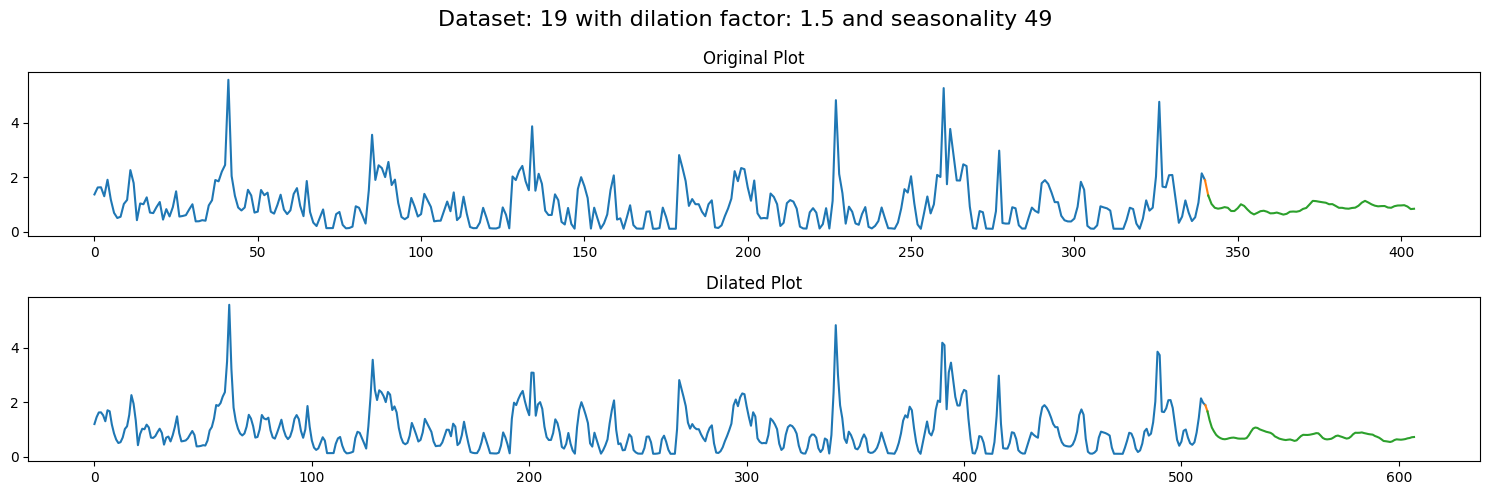

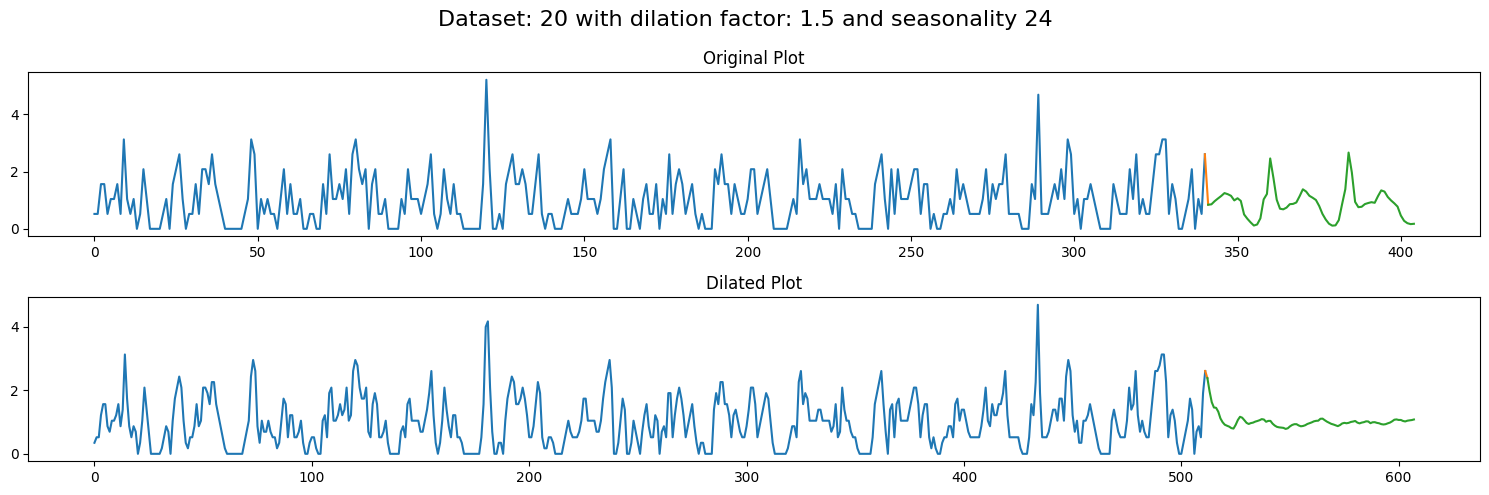

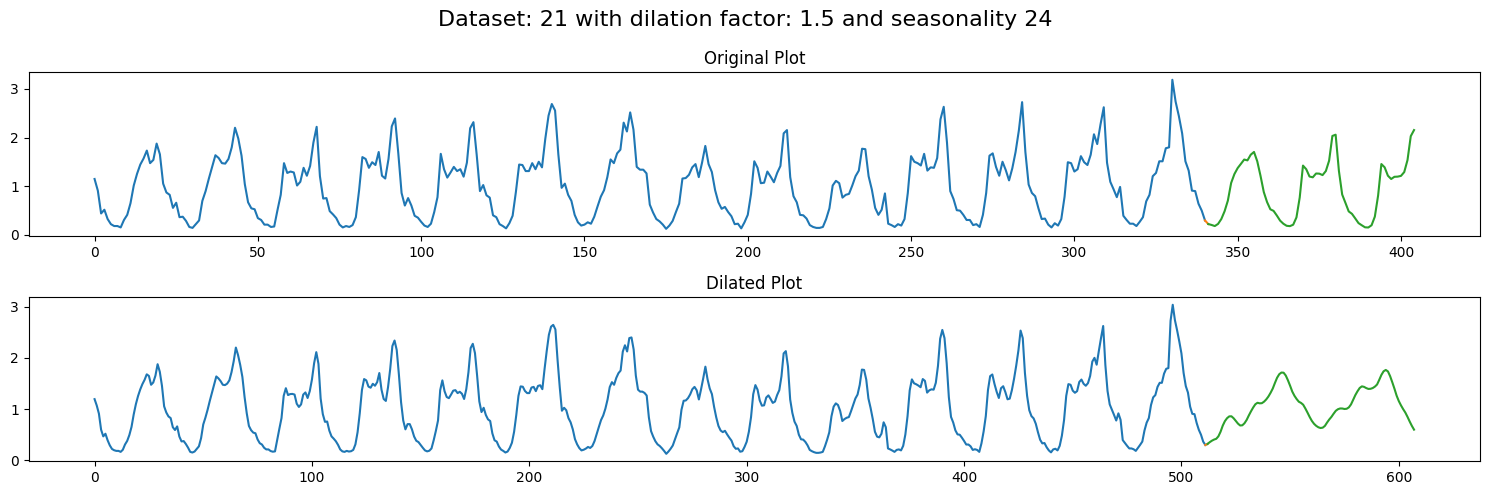

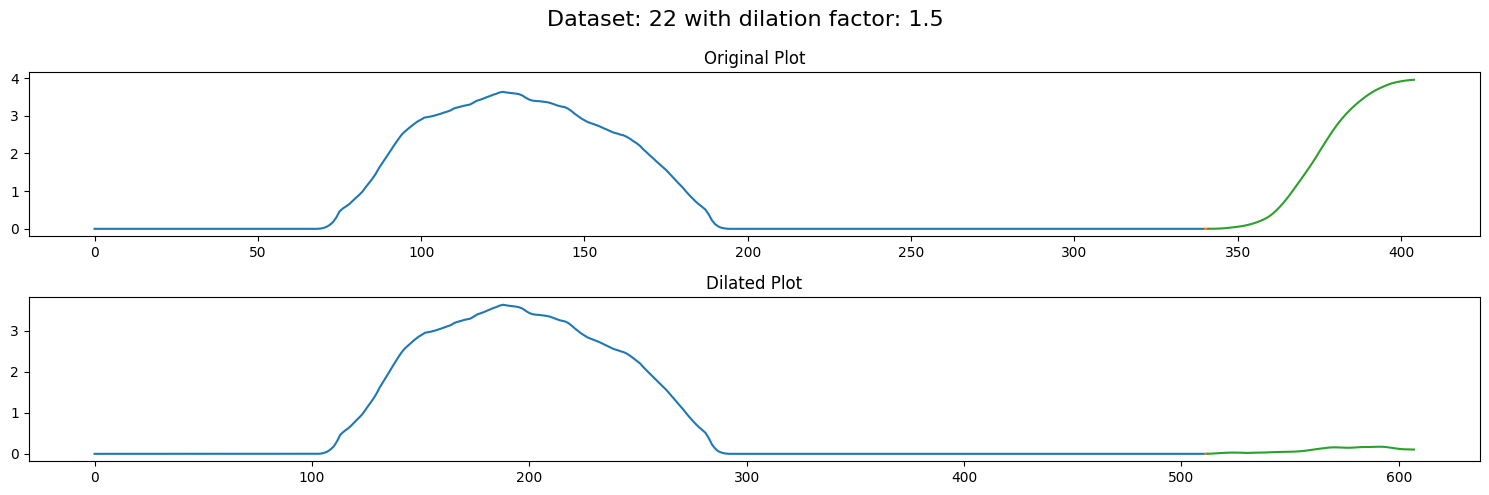

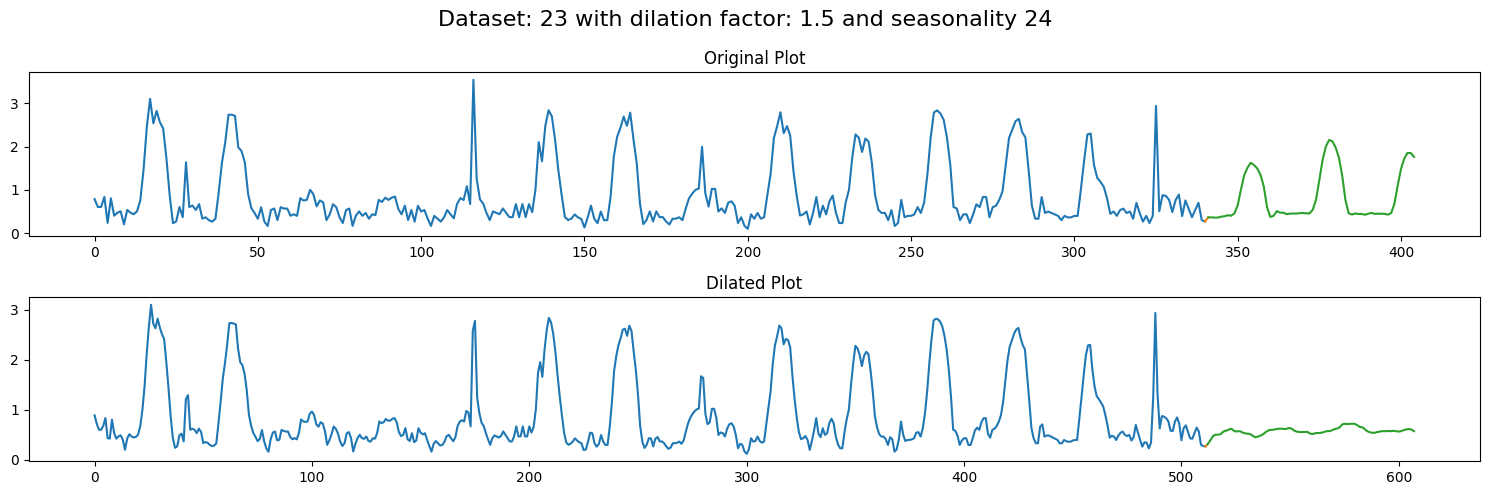

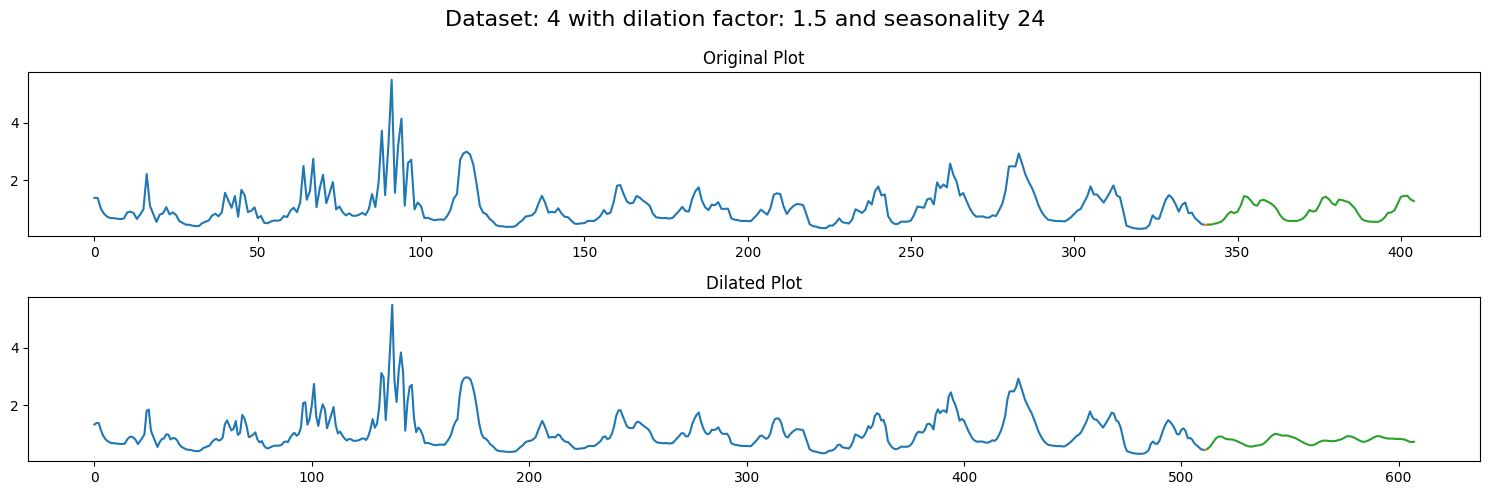

In [25]:
# Plotting dilation
ctx_len = 512
pred_len = 96
x, y = load_dataset("tsmixup", ctx_len=ctx_len)
# periods = torch.tensor([24, 32, 48, 7, 14, 15, 9])
# x = generate_sin(1, periods, m=torch.zeros_like(periods)).to('cpu')
dilation_factor = 1.5
x_dilated = linear_dilation(x, dilation_factor)

# Various Plots
batches = [19,20,21,22,23,4]
# batches = range(len(periods))
plt_x = x[batches]
plt_x_dilated = linear_dilation(plt_x, dilation_factor)
y_ar = ar_predictions(patchtst, plt_x.to(device), pred_length=pred_len)
y_ar_dilated = ar_predictions(patchtst, plt_x_dilated.to(device), pred_length=pred_len)

for batch in range(len(batches)):
    fig, axes = plt.subplots(2, figsize=(15,5))
    x_start = (int(ctx_len/dilation_factor) if dilation_factor > 1 else ctx_len)
    y_end = (int(pred_len/dilation_factor) if dilation_factor > 1 else pred_len)
    x_start_dilated = (ctx_len if dilation_factor > 1 else int(ctx_len*dilation_factor))
    y_end_dilated = (pred_len if dilation_factor > 1 else int(pred_len*dilation_factor))
    axes[0].plot(plt_x[batch, -x_start:].detach().cpu())
    axes[0].plot([x_start-1, x_start], [plt_x[batch,-1].item(), y_ar[batch,0].item()])
    axes[0].plot(torch.arange(y_end) + x_start, y_ar[batch, :y_end].detach().cpu().numpy())
    axes[0].set_title("Original Plot")
    
    
    axes[1].set_title("Dilated Plot")
    axes[1].plot(plt_x_dilated[batch, -x_start_dilated:].detach().cpu())
    axes[1].plot([x_start_dilated-1,x_start_dilated], [plt_x_dilated[batch,-1].item(), y_ar_dilated[batch,0].item()])
    axes[1].plot(torch.arange(y_end_dilated) + x_start_dilated, y_ar_dilated[batch, :y_end_dilated].detach().cpu().numpy())

    # get seasonality
    finder = SeasonalityFinder(plt_x[batch], min_period=6)
    result = finder.autocorrelation_method()
    if len(result['periods']) > 0 and result['scores'][0] > 0.5:
        # print(result['periods'][:5], result['scores'][:5])
        plt.suptitle(f"Dataset: {batches[batch]} with dilation factor: {dilation_factor} and seasonality {result['periods'][0]}", fontsize=16)
    else:
        plt.suptitle(f"Dataset: {batches[batch]} with dilation factor: {dilation_factor}", fontsize=16)
    plt.tight_layout()
    plt.show()

## What neurons don't change when dilating context

In [26]:
# Run model and get activations on tsmixup
batch_size = 1000
dilation_factor = 1.5 # keep this >1 due to padding
activations = [[] for _ in range(patchtst.cfg.n_layers)]
activations_dilated = [[] for _ in range(patchtst.cfg.n_layers)]

for i in tqdm(range(len(val_dataset) // batch_size)):
    ts = torch.arange(batch_size) + batch_size * i
    x, _ =  load_dataset('tsmixup', torch.arange(batch_size) + i*batch_size)
    x_dilated = linear_dilation(x, dilation_factor)
    mlp_activations = []
    mlp_hooks = []
    mlp_activations_dilated = []
    mlp_hooks_dilated = []
    for i in range(patchtst.cfg.n_layers):
        mlp_activation = torch.zeros((x.shape[0], patchtst.cfg.num_patches, patchtst.cfg.d_mlp))
        mlp_activations.append(mlp_activation)
        get_mlp_activations = functools.partial(get_activations, activations=mlp_activation)
        mlp_hooks.append((f"blocks.{i}.mlp.hook_post", get_mlp_activations))

        mlp_activation_dilated = torch.zeros((x.shape[0], patchtst.cfg.num_patches, patchtst.cfg.d_mlp))
        mlp_activations_dilated.append(mlp_activation_dilated)
        get_mlp_activations_dilated = functools.partial(get_activations, activations=mlp_activation_dilated)
        mlp_hooks_dilated.append((f"blocks.{i}.mlp.hook_post", get_mlp_activations_dilated))

    y = patchtst.run_with_hooks(x, fwd_hooks=mlp_hooks)
    y_dilated = patchtst.run_with_hooks(x_dilated, fwd_hooks=mlp_hooks_dilated)
    for i in range(patchtst.cfg.n_layers):
        activations[i].append(mlp_activations[i].detach().cpu())
        activations_dilated[i].append(mlp_activations_dilated[i].detach().cpu())
        
all_activations = torch.stack([torch.cat(layer) for layer in activations])
all_activations_dilated = torch.stack([torch.cat(layer) for layer in activations_dilated])

100%|██████████| 17/17 [00:02<00:00,  6.46it/s]


Top 10 neurons with the lowest change after dilation:
MAPE: 0.301 R2: 0.853 MAE: 0.049 layer: 0, patch: 31, neuron: 174, sparsity: 0.418, entropy: 2.163


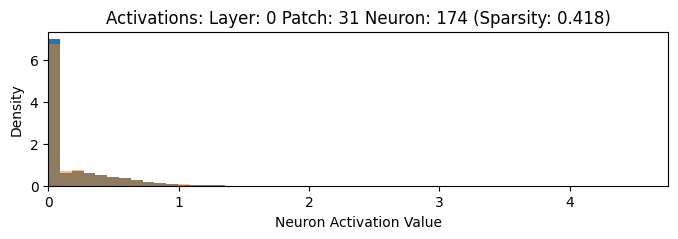

MAPE: 0.221 R2: 0.839 MAE: 0.103 layer: 0, patch: 31, neuron: 206, sparsity: 0.751, entropy: 3.586


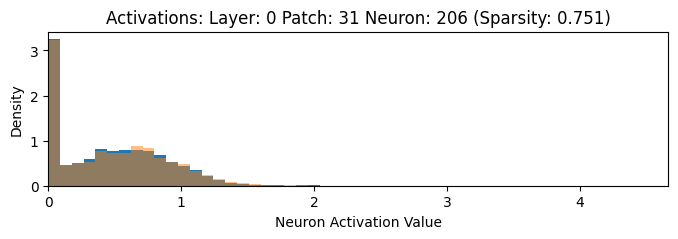

MAPE: 0.287 R2: 0.827 MAE: 0.112 layer: 0, patch: 31, neuron: 84, sparsity: 0.611, entropy: 3.019


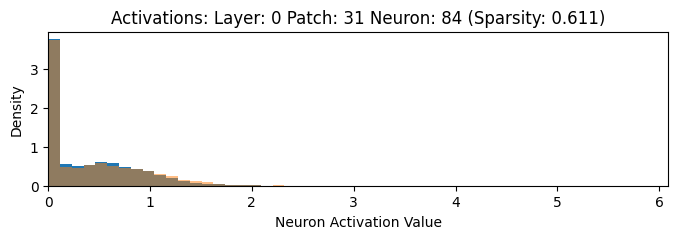

MAPE: 0.646 R2: 0.820 MAE: 0.001 layer: 0, patch: 31, neuron: 167, sparsity: 0.002, entropy: 0.023


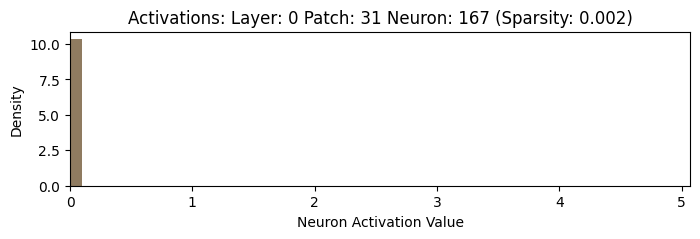

MAPE: 0.213 R2: 0.814 MAE: 0.135 layer: 0, patch: 31, neuron: 111, sparsity: 0.946, entropy: 3.387


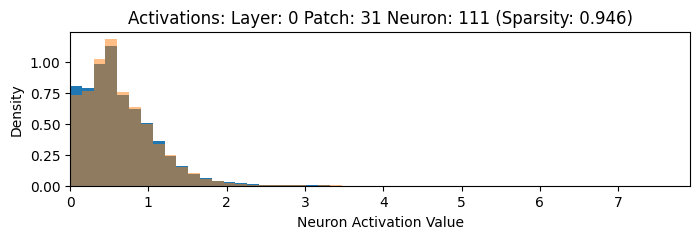

MAPE: 0.568 R2: 0.814 MAE: 0.001 layer: 0, patch: 31, neuron: 152, sparsity: 0.002, entropy: 0.027


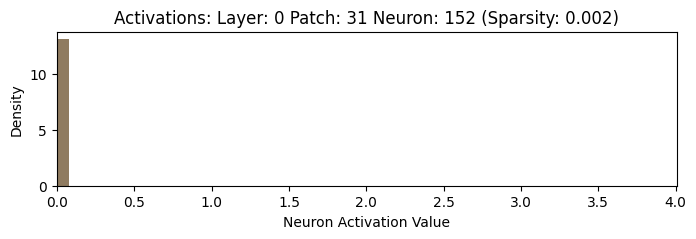

MAPE: 0.594 R2: 0.808 MAE: 0.001 layer: 0, patch: 31, neuron: 66, sparsity: 0.005, entropy: 0.050


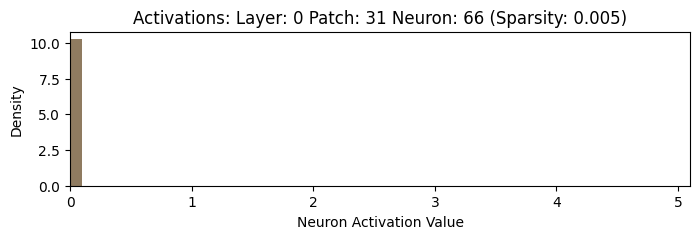

MAPE: 0.322 R2: 0.773 MAE: 0.091 layer: 0, patch: 31, neuron: 144, sparsity: 0.843, entropy: 2.808


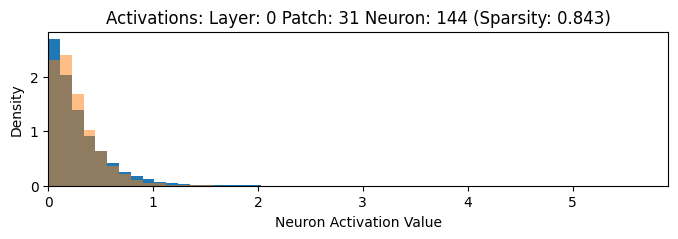

MAPE: 0.146 R2: 0.770 MAE: 0.140 layer: 0, patch: 31, neuron: 79, sparsity: 0.960, entropy: 3.618


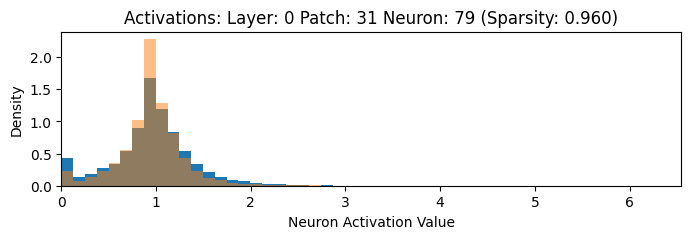

MAPE: 0.358 R2: 0.734 MAE: 0.110 layer: 0, patch: 31, neuron: 117, sparsity: 0.617, entropy: 2.939


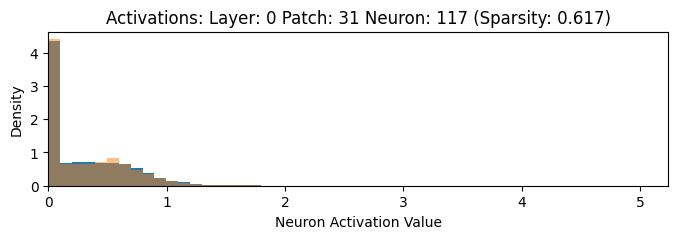

In [27]:
# Get MAPE and R2 of neurons
k = 10
use_mape = False
mae = torch.mean(F.l1_loss(all_activations, all_activations_dilated, reduction='none'), dim=1)
mse = torch.mean(F.mse_loss(all_activations, all_activations_dilated, reduction='none'), dim=1)

# Ignore sparse neurons
min_sparsity = 1e-3
neuron_sparsities = torch.mean((all_activations > 0).float(), dim=1)
neuron_sparsity_mask = torch.bitwise_not(neuron_sparsities >= min_sparsity)
mae[neuron_sparsity_mask] = torch.max(mae)
mse[neuron_sparsity_mask] = torch.max(mse)

neuron_entropy = torch.abs(shannon_entropy(all_activations))

# Score is mape or r2
r2 = 1 - (mse / torch.var(all_activations, dim=1))
mape = mae / torch.mean(all_activations, dim=1)
# Goal is to find neurons that aren't static but don't change
topk_values, topk_ind = torch.topk((mape if use_mape else r2).flatten(), k, largest=(not use_mape))
print(f"Top {k} neurons with the lowest change after dilation:")
for val, ind in zip(topk_values, topk_ind):
    layer, patch, neuron = torch.unravel_index(ind, corr.shape)
    print(f"MAPE: {mape[layer, patch, neuron]:.3f} R2: {r2[layer, patch, neuron]:.3f} MAE: {mae[layer, patch, neuron]:.3f} layer: "
          f"{layer.item()}, patch: {patch.item()}, neuron: {neuron.item()}, sparsity: {neuron_sparsities[layer, patch, neuron]:.3f}, "
          f"entropy: {neuron_entropy[layer, patch, neuron]:.3f}")
    plt.figure(figsize=(8,2))
    hist, bins, _ = plt.hist(all_activations[layer, :, patch, neuron], bins=50, density=True, alpha=1)
    hist, bins, _ = plt.hist(all_activations_dilated[layer, :, patch, neuron], bins=bins, density=True, alpha=0.5)
    plt.xlim(0, None)
    plt.title(f"Activations: Layer: {layer} Patch: {patch} Neuron: {neuron} (Sparsity: {neuron_sparsities[layer, patch, neuron]:.3f})")
    plt.xlabel("Neuron Activation Value")
    plt.ylabel("Density")
    plt.show()

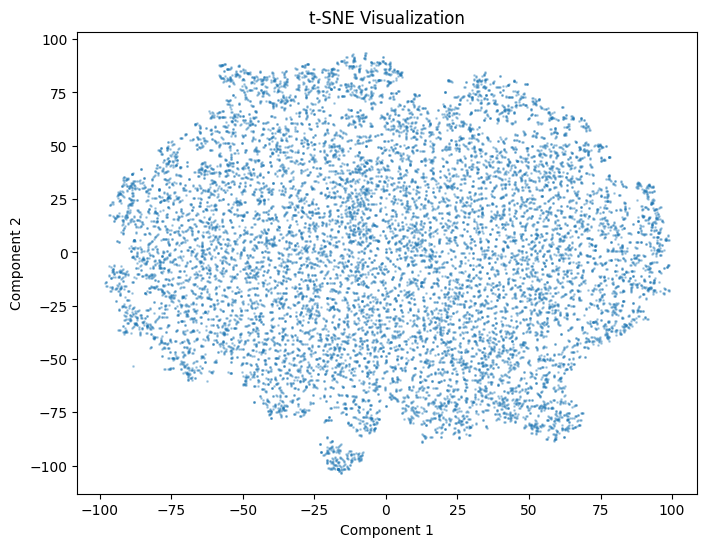

In [66]:
# Clustering activations
tsne = TSNE(n_components=2, random_state=42, perplexity=10, max_iter=1000)
reduced_data = tsne.fit_transform(all_activations[0,:,31])

plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:,0], reduced_data[:,1], s=1, alpha=0.3)
plt.title('t-SNE Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## Neuron correlation with 24-step seasonality

In [80]:
x, y = load_dataset('tsmixup')
finder = SeasonalityFinder(plt_x[batch], min_period=6)
activations = [[] for _ in range(patchtst.cfg.n_layers)]
result = finder.autocorrelation_method()

# Run model and get activations on tsmixup
batch_size = 1000
is_daily = []

for i in tqdm(range(len(val_dataset) // batch_size)):
    ts = torch.arange(batch_size) + batch_size * i
    x, _ =  load_dataset('tsmixup', torch.arange(batch_size) + i*batch_size)
    mlp_activations = []
    mlp_hooks = []
    # Get seasonality
    for x_single in x:
        finder = SeasonalityFinder(x_single, min_period=23, max_period=50)
        result = finder.autocorrelation_method()
        if len(result['periods']) > 0 and result['scores'][0] > 0.7 and result['periods'][0] == 24:
            is_daily.append(1)
        else:
            is_daily.append(0)
    # Setup mlp hooks
    for i in range(patchtst.cfg.n_layers):
        mlp_activation = torch.zeros((x.shape[0], patchtst.cfg.num_patches, patchtst.cfg.d_mlp))
        mlp_activations.append(mlp_activation)
        get_mlp_activations = functools.partial(get_activations, activations=mlp_activation)
        mlp_hooks.append((f"blocks.{i}.mlp.hook_post", get_mlp_activations))

    # Run model
    y = patchtst.run_with_hooks(x, fwd_hooks=mlp_hooks)
    for i in range(patchtst.cfg.n_layers):
        activations[i].append(mlp_activations[i].detach().cpu())
        
all_activations = torch.stack([torch.cat(layer) for layer in activations])

is_daily = torch.tensor(is_daily, dtype=torch.float32)
print(f"{torch.mean(is_daily)*100}% of time series have clear 24-step seasonality")

  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:01,  6.98it/s]/tmp/ipykernel_1909869/1764145994.py:222: RuntimeWarning: invalid value encountered in divide
  autocorr = autocorr / autocorr[0]  # Normalize
100%|██████████| 17/17 [00:02<00:00,  6.94it/s]


31.36470603942871% of time series have clear 24-step seasonality


In [103]:
# Get Absolute Valued Point Biserial Correlation
corr = torch.zeros((patchtst.cfg.n_layers, patchtst.cfg.num_patches, patchtst.cfg.d_mlp))
for layer in range(patchtst.cfg.n_layers):
    for patch in tqdm(range(patchtst.cfg.num_patches)):
        for neuron in range(patchtst.cfg.d_mlp):
            correlation, _ = pointbiserialr(all_activations[layer, :, patch, neuron].detach().cpu(), is_daily)
            corr[layer, patch, neuron] = torch.tensor(correlation)

corr = torch.abs(torch.nan_to_num(corr, 0))

 97%|█████████▋| 31/32 [00:05<00:00,  5.54it/s]/extra/datalab_scratch0/ctadler/time_series_models/uni2ts/venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5405: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
100%|██████████| 32/32 [00:05<00:00,  5.58it/s]


Top 10 neurons with the highest correlation to 24-seasonality:
Correlation: 0.523 layer: 1, patch: 30, neuron: 99
Correlation: 0.516 layer: 2, patch: 30, neuron: 115
Correlation: 0.513 layer: 1, patch: 11, neuron: 113
Correlation: 0.513 layer: 1, patch: 21, neuron: 99
Correlation: 0.506 layer: 1, patch: 9, neuron: 99
Correlation: 0.504 layer: 1, patch: 11, neuron: 254
Correlation: 0.500 layer: 2, patch: 24, neuron: 115
Correlation: 0.500 layer: 1, patch: 29, neuron: 113
Correlation: 0.496 layer: 1, patch: 18, neuron: 99
Correlation: 0.491 layer: 1, patch: 20, neuron: 113
Error when predicting from the best neuron
LR MAE: 2.08E-01 MSE: 2.08E-01


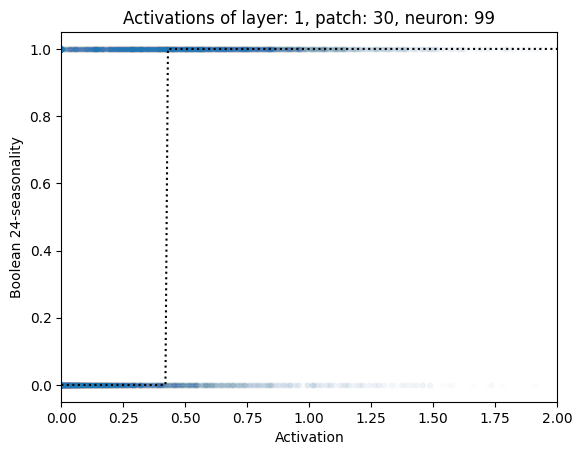

In [105]:
# Get Point Biserial Correlation of neurons with whether a TS has 24 seasonality
k = 10
top10_values, top10_ind = torch.topk(corr.flatten(), k=k)
print(f"Top {k} neurons with the highest correlation to 24-seasonality:")
for val, ind in zip(top10_values, top10_ind):
    layer, patch, neuron = torch.unravel_index(ind, corr.shape)
    print(f"Correlation: {val:.3f} layer: {layer.item()}, patch: {patch.item()}, neuron: {neuron.item()}")
    
# Plot best activations against period
global_argmax = torch.argmax(corr)
layer, patch, neuron = torch.unravel_index(global_argmax, corr.shape)

X = all_activations[layer, :, patch, neuron][:,None].detach().cpu()
X_train, X_test, y_train, y_test = train_test_split(X, is_daily, test_size=0.1)
reg = LogisticRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("Error when predicting from the best neuron")
print(f"LR MAE: {mean_absolute_error(y_test, y_pred):.2E} MSE: {mean_squared_error(y_test, y_pred):.2E}")


plt.scatter(all_activations[layer, :, patch, neuron].detach().cpu(), is_daily, s=10, alpha=0.01)
plt.ylabel(f"Boolean 24-seasonality")
plt.xlabel("Activation")
xmin, xmax = plt.xlim()
scale = 100
x_plt = torch.arange(int(xmax)*scale) / scale
plt.plot(x_plt, reg.predict(x_plt[:,None]), c='black', ls=':')
plt.xlim(int(xmin), int(xmax)-1)
plt.title(f"Activations of layer: {layer.item()}, patch: {patch.item()}, neuron: {neuron.item()}")
plt.show()

In [117]:
# Train a LR and Lasso model to predict 24-hour periodicity 
layer = 0
patch = [31] # [31]
X = all_activations[layer, :, patch].flatten(start_dim=1).detach().cpu()
print(f"Predicting 24-hour periodicity")

X_train, X_test, y_train, y_test = train_test_split(X, is_daily, test_size=0.1)

reg = LogisticRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(f"LR Accuracy: {accuracy_score(y_test, y_pred):.3f} Non-zero coef: {np.sum(reg.coef_ != 0)}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# lasso = Lasso(alpha=0.0001)
reg_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.005, max_iter=1000)
reg_l1.fit(X_train_scaled, y_train)
y_reg_l1 = reg_l1.predict(X_test_scaled)
print(f"LR w/ L1 Accuracy: {accuracy_score(y_test, y_reg_l1):.3f} Non-zero coef: {np.sum(reg_l1.coef_ != 0)}")
# print(y)

Predicting 24-hour periodicity


/extra/datalab_scratch0/ctadler/time_series_models/uni2ts/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy: 0.854 Non-zero coef: 255
LR w/ L1 Accuracy: 0.812 Non-zero coef: 56


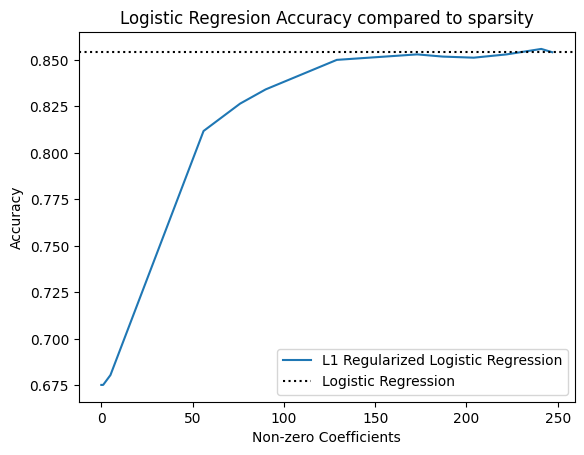

In [124]:
# Plotting LR performance with varying sparsity
C = np.array([1,0.5,0.2,0.1,0.07,0.05,0.02,0.01,0.0075,0.005,0.001,0.00075,0.0005,0.0002,0.0001])
lr_reg_accuracy = []
lr_reg_sparse = []
for alpha in C:
    lr_reg = LogisticRegression(penalty='l1', solver='liblinear', C=alpha, max_iter=1000)
    lr_reg.fit(X_train_scaled, y_train)
    y_lr_reg = lr_reg.predict(X_test_scaled)
    lr_reg_accuracy.append(accuracy_score(y_test, y_lr_reg))
    lr_reg_sparse.append(np.sum(lr_reg.coef_ != 0))

plt.plot(lr_reg_sparse, lr_reg_accuracy, label='L1 Regularized Logistic Regression')
plt.axhline(accuracy_score(y_test, y_pred), c='black', ls=':', label='Logistic Regression')
plt.xlabel("Non-zero Coefficients")
plt.ylabel("Accuracy")
plt.title("Logistic Regresion Accuracy compared to sparsity")
plt.legend()
plt.show()